In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

In [3]:
def setupSlicer(orbitFile, Hrange, obsFile=None):
    # Read the orbit file and set the H values for the slicer.
    slicer = slicers.MoObjSlicer()
    slicer.readOrbits(orbitFile, Hrange=Hrange)
    if obsFile is not None:
        slicer.readObs(obsFile)
    return slicer

In [4]:
def setupBundle(slicer, metadata, nyr, snrLimit=5):
    constraint = 'night <= %d' %(nyr * 365)
    md = metadata + ' year %d, 3 pairs in 15 nights' % nyr
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % (runName, md)}
    summaryMetrics = [metrics.MoCompletenessMetric(), metrics.MoCumulativeCompletenessMetric()]
    plotFuncs = [plots.MetricVsH()]
    metric = metrics.DiscoveryMetric(nObsPerNight=2, tMin=0, tMax=90./60./24.,
                                    nNightsPerWindow=3, tWindow=15, snrLimit=snrLimit)
    childMetrics = {'N_Chances_All': metrics.Discovery_N_ChancesMetric(metric)}
    bundle = mmb.MoMetricBundle(metric, slicer, constraint,
                                runName=runName, metadata=md,
                                childMetrics=childMetrics,
                                plotDict=plotDict, plotFuncs=plotFuncs)
    bundle.childBundles['N_Chances_All'].setSummaryMetrics(summaryMetrics)
    return bundle

In [5]:
def setupStackers(trailingLossCol):
    # trailingLossCol = 'dmagDetect' (PSF detection) or 'dmagTrail' (intrinsic SNR loss due to trailing)
    magLimitStacker = stackers.MagLimitStacker(lossCol=trailingLossCol)
    allStackers = stackers.AllMoStackers(magLimitStacker=magLimitStacker)
    return allStackers

In [6]:
opsim = 'minion_1016'
orbitFile = 'orbits/pha20141031.des'
obsFile = os.path.join(opsim, opsim + '__pha20141031_obs.txt')
#obsFile = os.path.join(opsim, opsim + '_tmp_obs.txt')
Hrange = np.arange(12, 28, .5)

In [7]:
runName = opsim
nyr = 10
metadata = 'PHA'

In [8]:
slicer = setupSlicer(orbitFile, Hrange, obsFile=obsFile)

In [9]:
bundle_detect5 = setupBundle(slicer, metadata + ' detect SNR=5', nyr, 5)
bundle_trail5 = setupBundle(slicer, metadata + ' trail SNR=5', nyr, 5)
bundle_detect4 = setupBundle(slicer, metadata + ' detect SNR=4', nyr, 4)
bundle_trail4 = setupBundle(slicer, metadata + ' trail SNR=4', nyr, 4)

In [10]:
allstackers_detect = setupStackers('dmagDetect')
allstackers_trail = setupStackers('dmagTrail')

In [11]:
bg = mmb.MoMetricBundleGroup({0: bundle_detect4, 1: bundle_detect5}, outDir='losses', resultsDb=None, 
                             allStackers=allstackers_detect)
bg.runAll()
bg.writeAll()
bg.summaryAll()

Calculated all metrics.
Saving metric bundles.


/Users/lynnej/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [12]:
bg = mmb.MoMetricBundleGroup({0: bundle_trail4, 1: bundle_trail5}, outDir='losses', resultsDb=None, 
                             allStackers=allstackers_trail)
bg.runAll()
bg.writeAll()
bg.summaryAll()

Calculated all metrics.
Saving metric bundles.


In [13]:
def makeCompletenessBundle(bundle, summaryName='CumulativeCompleteness',
                           Hmark=None, resultsDb=None):
    # Make a 'mock' metric bundle from a bundle which had the
    # MoCompleteness or MoCumulativeCompleteness summary metrics run.
    # This lets us use a normal plotHandler to generate combined plots.
    try:
        bundle.summaryValues[summaryName]
    except (TypeError, KeyError):
        if summaryName == 'Completeness':
            metric = metrics.MoCompletenessMetric()
        else:
            metric = metrics.MoCumulativeCompletenessMetric()
        bundle.setSummaryMetrics(metric)
        bundle.computeSummaryStats(resultsDb)
    plotFuncs = [plots.MetricVsH()]
    completeness = ma.MaskedArray(data=bundle.summaryValues[summaryName]['value'],
                                  mask=np.zeros(len(bundle.summaryValues[summaryName]['value'])),
                                  fill_value=0)
    mb = mmb.MoMetricBundle(metrics.MoCompletenessMetric(metricName=summaryName),
                            bundle.slicer, constraint=None, metadata=bundle.metadata,
                            runName=bundle.runName, plotFuncs=plotFuncs)
    plotDict = {}
    plotDict.update(bundle.plotDict)
    plotDict['label'] = bundle.metadata
    mb.metricValues = completeness
    if Hmark is not None:
        metric = metrics.ValueAtHMetric(Hmark=Hmark)
        mb.setSummaryMetrics(metric)
        mb.computeSummaryStats(resultsDb)
        val = mb.summaryValues['Value At H=%.1f' % Hmark]
        if summaryName == 'Completeness':
            plotDict['label'] += ' : @ H(=%.1f) = %.1f%s' % (Hmark, val*100, '%')
        else:
            plotDict['label'] += ' : @ H(<=%.1f) = %.1f%s' % (Hmark, val*100, '%')
    mb.setPlotDict(plotDict)
    return mb

In [14]:
comp_detect5 = makeCompletenessBundle(bundle_detect5.childBundles['N_Chances_All'], Hmark=22)
comp_trail5 = makeCompletenessBundle(bundle_trail5.childBundles['N_Chances_All'], Hmark=22)
comp_detect4 = makeCompletenessBundle(bundle_detect4.childBundles['N_Chances_All'], Hmark=22)
comp_trail4 = makeCompletenessBundle(bundle_trail4.childBundles['N_Chances_All'], Hmark=22)

In [15]:
ph = plots.PlotHandler()

/Users/lynnej/sims_maf_sso/python/lsst/sims/maf/plots/plotHandler.py:460: UserWarning: Found more than one value to be set for "title" in the plotDicts. Will reset to default value. (found values ['minion_1016: PHA detect SNR=5 year 10, 3 pairs in 15 nights', 'minion_1016: PHA trail SNR=5 year 10, 3 pairs in 15 nights', 'minion_1016: PHA detect SNR=4 year 10, 3 pairs in 15 nights', 'minion_1016: PHA trail SNR=4 year 10, 3 pairs in 15 nights'])
  ' Will reset to default value. (found values %s)' % values)


1

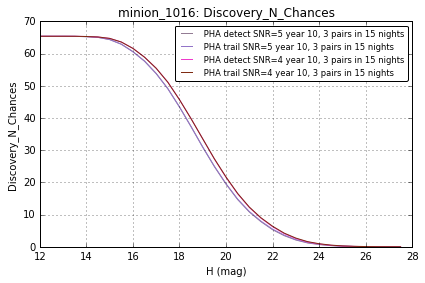

In [16]:
ph.setMetricBundles([bundle_detect5.childBundles['N_Chances_All'], bundle_trail5.childBundles['N_Chances_All'],
                    bundle_detect4.childBundles['N_Chances_All'], bundle_trail4.childBundles['N_Chances_All']])
ph.plot(plotFunc=plots.MetricVsH())

1

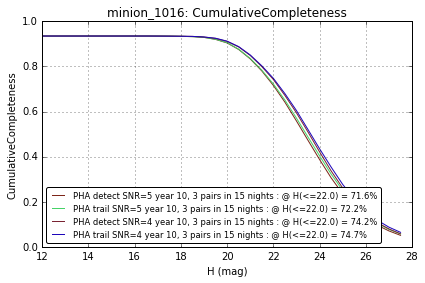

In [17]:
ph.setMetricBundles([comp_detect5, comp_trail5, comp_detect4, comp_trail4])
plotDict = {'legendloc': 'lower left'}
ph.plot(plotFunc=plots.MetricVsH(), plotDicts=plotDict)